In [3]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print(DEVICE)

cuda


Using device: cuda
Classes: ['happy', 'neutral', 'sad']
Epoch 1: Train Acc=69.66% | Val Acc=73.78% | Test Acc=72.45% || Train Loss=0.6877 | Val Loss=0.6540 | Test Loss=0.6588
Epoch 2: Train Acc=75.82% | Val Acc=74.96% | Test Acc=74.61% || Train Loss=0.5589 | Val Loss=0.5720 | Test Loss=0.5750
Epoch 3: Train Acc=77.51% | Val Acc=74.84% | Test Acc=76.63% || Train Loss=0.5254 | Val Loss=0.5702 | Test Loss=0.5385
Epoch 4: Train Acc=79.91% | Val Acc=77.22% | Test Acc=76.38% || Train Loss=0.4856 | Val Loss=0.5563 | Test Loss=0.5839
Epoch 5: Train Acc=80.42% | Val Acc=75.78% | Test Acc=75.76% || Train Loss=0.4658 | Val Loss=0.5572 | Test Loss=0.5674
Epoch 6: Train Acc=82.30% | Val Acc=78.16% | Test Acc=77.53% || Train Loss=0.4348 | Val Loss=0.5364 | Test Loss=0.5444
Epoch 7: Train Acc=83.46% | Val Acc=76.66% | Test Acc=76.92% || Train Loss=0.4036 | Val Loss=0.5805 | Test Loss=0.6040
Epoch 8: Train Acc=84.49% | Val Acc=77.07% | Test Acc=76.77% || Train Loss=0.3858 | Val Loss=0.5739 | Test Loss

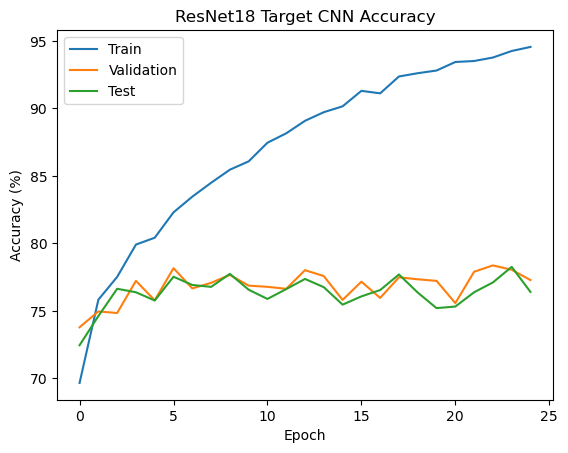

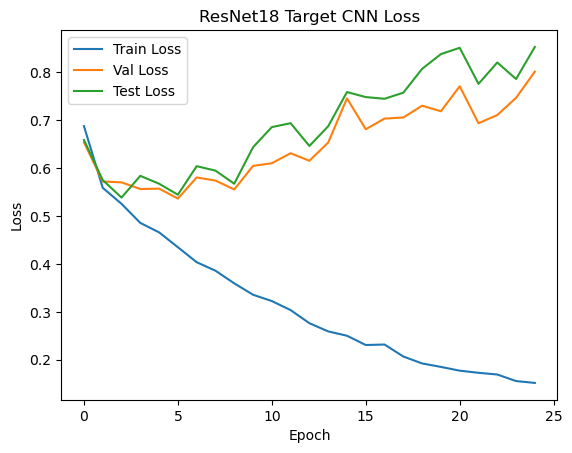

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# PATHS
TRAIN_DIR = "/home/student/Downloads/copycat_fer_project/FER2013_3 Class/train"
TEST_DIR  = "/home/student/Downloads/copycat_fer_project/FER2013_3 Class/test"
SAVE_PATH = "/home/student/Downloads/copycat_fer_project/target_resnet18_3class.pth"

# CONFIG
BATCH_SIZE = 64
EPOCHS = 25
LR = 0.001
NUM_CLASSES = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", DEVICE)

# TRANSFORMS
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

test_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

# DATASETS
full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_tf)

print("Classes:", full_train.classes)

val_size = int(0.2 * len(full_train))
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# MODEL (Dropout added ONLY in classifier)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

model.fc = nn.Sequential(
    nn.Dropout(p=0.5),                      
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)

model = model.to(DEVICE)

# PARTIAL FREEZE (layer4 + fc)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=1e-4
)

# METRICS
train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss, test_loss = [], [], []

# TRAIN LOOP
for epoch in range(EPOCHS):

    # TRAIN
    model.train()
    correct, total, running_loss = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    ta = 100 * correct / total
    tl = running_loss / len(train_loader)

    # VALIDATION
    model.eval()
    vc, vt, vloss = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vloss += loss.item()
            pred = out.argmax(1)
            vc += (pred == y).sum().item()
            vt += y.size(0)

    va = 100 * vc / vt
    vloss /= len(val_loader)

    #TEST 
    tc, tt, tloss = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            tloss += loss.item()
            pred = out.argmax(1)
            tc += (pred == y).sum().item()
            tt += y.size(0)

    te = 100 * tc / tt
    tloss /= len(test_loader)

    train_acc.append(ta)
    val_acc.append(va)
    test_acc.append(te)
    train_loss.append(tl)
    val_loss.append(vloss)
    test_loss.append(tloss)

    print(
        f"Epoch {epoch+1}: "
        f"Train Acc={ta:.2f}% | Val Acc={va:.2f}% | Test Acc={te:.2f}% || "
        f"Train Loss={tl:.4f} | Val Loss={vloss:.4f} | Test Loss={tloss:.4f}"
    )

# SAVE MODEL
torch.save(model.state_dict(), SAVE_PATH)
print("Target model saved:", SAVE_PATH)

# PLOTS
plt.figure()
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.plot(test_acc, label="Test")
plt.legend()
plt.title("ResNet18 Target CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()

plt.figure()
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.plot(test_loss, label="Test Loss")
plt.legend()
plt.title("ResNet18 Target CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
